In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/My Drive/Text2EF"

In [ ]:
!touch "/content/drive/My Drive/Text2EF/test_results.json"

In [ ]:
import json
import os

class JsonFileManager:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = self._load_json()

    def does_item_exist(self, item_id):
        for item in self.data:
            if item['id'] == item_id:
                return True
        return False

    def _load_json(self):
        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as file:
                return json.load(file)
        return []

    def _save_json(self):
        with open(self.filepath, 'w') as file:
            json.dump(self.data, file, indent=4)



    def append_or_update(self, item):
        item_id = item.get('id')
        if item_id is None:
            raise ValueError("Item must have an 'id' field")

        for idx, existing_item in enumerate(self.data):
            if existing_item['id'] == item_id:
                self.data[idx] = item
                self._save_json()
                return

        self.data.append(item)
        self._save_json()

test_results_json_manager = JsonFileManager("/content/drive/My Drive/Text2EF/test_results_model-8b_context-8192_pretrained-warmup_steps_500-max_steps_200.json")

In [ ]:
from unsloth import FastLanguageModel

max_seq_length = 8192 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "unsloth/Meta-Llama-3.1-8B",
    # model_name = "/content/drive/My Drive/Text2EF/ef_model",
    model_name = "/content/drive/My Drive/Text2EF/ef_model-max_steps_200-warmup_steps_500",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

# https://github.com/unslothai/unsloth/issues/416
tokenizer.add_special_tokens({"pad_token": "<|reserved_special_token_0|>"})
model.config.pad_token_id = tokenizer.pad_token_id # updating model config
tokenizer.padding_side = 'right' # padding to right (otherwise SFTTrainer shows warning)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


RuntimeError: Incorrect path_or_model_id: '/content/drive/My Drive/Text2EF/ef_model-max_steps_200-warmup_steps_500'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Already have LoRA adapters! We shall skip this step.


In [ ]:
from datasets import load_dataset, Split

def format_dataset(examples):
    texts = []
    for item in examples["prompt"]:
        text = item + tokenizer.eos_token
        texts.append(text)
    return { "text" : texts, }


train_dataset = load_dataset("andreirusu32/sql2ef", split=Split.TRAIN)
train_dataset = train_dataset.map(format_dataset, batched = True)

Generating train split:   0%|          | 0/2936 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/787 [00:00<?, ? examples/s]

Map:   0%|          | 0/2936 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset, Split

test_dataset = load_dataset("andreirusu32/sql2ef", split=Split.TEST)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
print(test_dataset[0])

In [ ]:
import torch

from tqdm import tqdm

FastLanguageModel.for_inference(model) # Enable native 2x faster inference
for item in tqdm(test_dataset):
    if test_results_json_manager.does_item_exist(item["query_id"]):
        print(f"Skipping query {item['query_id']}")
        continue

    prompt = item['prompt']

    inputs = tokenizer(
        [prompt],
        return_tensors = "pt",
    ).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens = 256,
        use_cache = True,
    )

    decoded_output = tokenizer.batch_decode(outputs)[0]

    output_string = "**Output:**"
    starts_at = decoded_output.rfind(output_string) + len(output_string)

    completion = decoded_output[starts_at:].strip()


   # We could have looked for eos, but sometimes it just adds a description to the query, or other text,
    # (even though instructed not to) so we can look for ";".
    # eos_pos = completion.find(EOS_TOKEN)
    # if eos_pos >= 0:
    #     completion = completion[:eos_pos]

    eos_pos = completion.find(";")
    if eos_pos >= 0:
        completion = completion[:eos_pos + 1]

    test_results_json_manager.append_or_update({
        "id": item["query_id"],
        "linq": completion
    })

    del inputs, outputs, decoded_output
    torch.cuda.empty_cache()


NameError: name 'FastLanguageModel' is not defined

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# 1st attempt
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "/content/drive/My Drive/Text2EF/outputs",
        save_steps=5
    ),
)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, EarlyStoppingCallback
from unsloth import is_bfloat16_supported

# 2nd attempt

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 500,
        max_steps = 200,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "/content/drive/My Drive/Text2EF/outputs-2",
        save_steps = 5,  # Save less frequently to reduce overhead.
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
import torch

torch.cuda.empty_cache()

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,936 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 200
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,0.549400
2,0.498200
3,0.572900
4,0.494300
5,0.591600
6,0.433500
7,0.506200
8,0.517600
9,0.510800
10,0.489000


In [ ]:
model.save_pretrained("/content/drive/My Drive/Text2EF/ef_model-max_steps_200-warmup_steps_500")
tokenizer.save_pretrained("/content/drive/My Drive/Text2EF/ef_model-max_steps_200-warmup_steps_500")

('/content/drive/My Drive/Text2EF/ef_model-max_steps_200-warmup_steps_500/tokenizer_config.json',
 '/content/drive/My Drive/Text2EF/ef_model-max_steps_200-warmup_steps_500/special_tokens_map.json',
 '/content/drive/My Drive/Text2EF/ef_model-max_steps_200-warmup_steps_500/tokenizer.json')

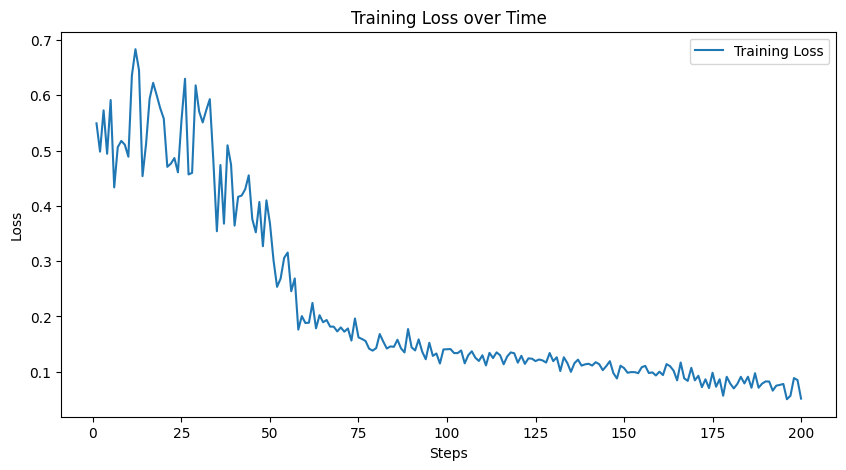

In [ ]:
import matplotlib.pyplot as plt

# Assuming the training logs are stored in `trainer.state.log_history`
train_loss = []
steps = []

for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        steps.append(log["step"])

plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss over Time")
plt.show()